# Data & AI - Die Prognose von Strompreisen
Ziel: Prognose des Strompreises mithilfe XGBoost

Die Prognose für den Strompreis  \( p_t = y \)  basiert auf den folgenden Variablen:

\[
\begin{aligned}
x_1 &= \text{Datum (Date)} \\
x_2 &= \text{Day-ahead Total Load Forecast [MW]} \\
x_3 &= \text{Actual Total Load [MW]} \\
x_4 &= \text{Solar Generation (MW)} \\
x_5 &= \text{Solar Hours (h)} \\
x_6 &= \text{Solar Prognose (Day-Ahead D-1 18:00)} \\
x_7 &= \text{Last w/o Solar Prognose}
\end{aligned}
\]

Die allgemeine Gleichung lautet:

\[
p_t = f(x_1, x_2, x_3, x_4, x_5, x_6, x_7)
\]

wobei:

- \( p_t \) der prognostizierte Strompreis zum Zeitpunkt \( t \) ist (monatlich), 
- \( f \) eine Funktion ist, die die Beziehung zwischen den erklärenden Variablen und dem Strompreis beschreibt.
\[
p_t = f(x_1, x_2, x_3, x_4, x_5, x_6, x_7)
\]


## Daten
Wir haben folgende finalen (bereinigten) Daten verwendet:

| Date            | Day-ahead Total Load Forecast [MW] | Actual Total Load [MW] | Solar Generation (MW) | Solar hours (h) | Solar Prognose (Day-Ahead D-1 18:00) | Solar_diff   | Solar_Prognose_diff | Monthly_Avg_Price | Price (EUR/MWhe)_y |
|-----------------|------------------------------------|------------------------|-----------------------|-----------------|-------------------------------------|--------------|---------------------|-------------------|--------------------|
| January 2015    | 166.302.682                        | 181.834.199            | 2.238.694             | 35,3            | 798,461862                          | 59.929       | 55.088              | 31,68             | 31,68              |
| February 2015   | 155.342.139                        | 169.561.960            | 5.484.017             | 88,0            | 2.028,640760                        | 60.619       | 55.779              | 36,69             | 36,69              |
| March 2015      | 169.030.231                        | 178.454.891            | 11.434.309            | 139,1           | 3.912,075336                        | 55.808       | 52.940              | 31,30             | 31,30              |
| April 2015      | 154.113.340                        | 160.907.650            | 17.741.556            | 224,5           | 6.088,122569                        | 49.431       | 47.402              | 29,78             | 29,78              |
| May 2015        | 151.195.903                        | 157.742.225            | 17.646.277            | 187,0           | 6.146,898891                        | 46.882       | 44.649              | 25,33             | 25,33              |
| ...             | ...                                | ...                    | ...                   | ...             | ...                                 | ...          | ...                 | ...               | ...                |
| March 2024      | 159.348.281                        | 160.770.407            | 19.604.796            | 120,3           | 6.483,432493                        | 47.462       | 47.098              | 64,66             | 64,66              |
| April 2024      | 150.003.318                        | 144.732.688            | 26.607.734            | 151,6           | 8.693,593889                        | 41.024       | 43.394              | 62,39             | 62,39              |
| May 2024        | 149.199.298                        | 140.954.515            | 34.256.739            | 215,3           | 11.233,927520                       | 35.858       | 38.906              | 67,28             | 67,28              |
| June 2024       | 146.887.657                        | 144.702.774            | 35.142.963            | 210,1           | 12.585,143542                       | 38.041       | 38.415              | 72,89             | 72,89              |
| July 2024       | 151.822.977                        | 150.906.256            | 37.850.255            | 236,5           | 12.993,181485                       | 38.003       | 38.025              | 67,71             | 67,71              |
         |



## Bereinigung der Daten

In diesem Abschnitt werden die Forecast-Solar Daten und die Forecast-Daten der restlichen Energieerzeugungsarten auf monatliche Basis gebracht und zur geeigneten, weiteren Verarbeitung für unser Modell bereinigt

## Importieren

* pandas und numpy Bibliothek und der entsprechenden Datensätze

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_Sonnenstunden = pd.read_csv("./Sonnenstunden.csv")
data_komplett = pd.read_csv("./Daten komplett_2.csv")
data_Preise = pd.read_csv("./electricity_prices.csv")
data_Solarenergie = pd.read_csv("./Monthly_solar_generation.csv")
data_Verbrauch_ahead = pd.read_csv("./monthly_day ahead loads.csv")

## Bereinigung von Data_Ahead_solar

Bilden monatlicher Durchschnitte und entfernen der Zeitzonen

<div style="font-size: 14px;">
Darstellung der nicht-bereinigten Daten
</div>

In [3]:
data_Ahead_solar_nichtbereinigt = pd.read_csv("./Day_Ahead_Solar.csv", header=0, usecols=[0,1,2])
data_Ahead_solar_nichtbereinigt

,Datum (MEZ),Solar,Solar Prognose (Day-Ahead D-1 18:00)
0,2015-01-01T00:00+01:00,0.0,0.0
1,2015-01-01T00:15+01:00,0.0,0.0
2,2015-01-01T00:30+01:00,0.0,0.0
3,2015-01-01T00:45+01:00,0.0,0.0
4,2015-01-01T01:00+01:00,0.0,0.0
...,...,...,...
339086,2024-09-04T19:00+02:00,1432.1,1366.2
339087,2024-09-04T19:15+02:00,772.5,732.6
339088,2024-09-04T19:30+02:00,372.0,352.2
339089,2024-09-04T19:45+02:00,130.7,122.8


<div style="font-size: 14px;">
Bereinigung
</div>

In [4]:
# Laden einer CSV-Datei und Speicherung als 'data_Ahead_solar' DataFrame
# - `header=0`: erste Zeile wird als Header verwendet
# - `usecols=[0,1,2]`: Nur Spalten 0, 1 und 2 der CSV-Datei werden importiert
# - `parse_dates=['Datum (MEZ)']`: Spalte 'Datum (MEZ)' wird als Datum interpretiert
data_Ahead_solar = pd.read_csv("./Day_Ahead_Solar.csv", header=0, usecols=[0,1,2], parse_dates=['Datum (MEZ)'])
# Datum-Spalte als Index setzen
data_Ahead_solar.set_index('Datum (MEZ)', inplace=True)

# Falls Index nicht DatetimeIndex ist, konvertiere ihn
if not isinstance(data_Ahead_solar.index, pd.DatetimeIndex):
    print(type(data_Ahead_solar.index[0]))
    data_Ahead_solar.index = pd.to_datetime(data_Ahead_solar.index, utc=True)

# Entferne Zeitzonen-Informationen, falls vorhanden
if data_Ahead_solar.index.tz is not None:
    data_Ahead_solar.index = data_Ahead_solar.index.tz_localize(None)

# Überprüfe Index nach Konvertierung
print(type(data_Ahead_solar.index))

# Aufsummierung der Werte für jeden Monat
Gesamt_ahead_solar = data_Ahead_solar.resample('M').sum()
Gesamt_ahead_solar.to_csv("Data_Ahead_solar_bereinigt.csv", index=True)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Bereinigte Daten:

In [5]:
Gesamt_ahead_solar

,Solar,Solar Prognose (Day-Ahead D-1 18:00)
Datum (MEZ),,
2014-12-31,0.0,0.0
2015-01-31,2238693.4,2376222.5
2015-02-28,5484011.5,5444871.8
2015-03-31,11434303.1,11657984.5
2015-04-30,17741565.0,17533793.0
...,...,...
2024-05-31,34256559.3,33432168.3
2024-06-30,35142943.2,36245213.4
2024-07-31,37850243.0,38667708.1


In [6]:
list(data_Ahead_solar.resample('M'))[0]

(Timestamp('2014-12-31 00:00:00'),
                      Solar  Solar Prognose (Day-Ahead D-1 18:00)
 Datum (MEZ)                                                     
 2014-12-31 23:00:00    0.0                                   0.0
 2014-12-31 23:15:00    0.0                                   0.0
 2014-12-31 23:30:00    0.0                                   0.0
 2014-12-31 23:45:00    0.0                                   0.0)

<div style="font-size: 14px;">
Ausgabe der bereinigten Daten
</div>

In [7]:
for index, solar in zip(Gesamt_ahead_solar.index, Gesamt_ahead_solar["Solar Prognose (Day-Ahead D-1 18:00)"]):
    print(index, ": ", solar)

2014-12-31 00:00:00 :  0.0
2015-01-31 00:00:00 :  2376222.5
2015-02-28 00:00:00 :  5444871.8
2015-03-31 00:00:00 :  11657984.5
2015-04-30 00:00:00 :  17533793.0
2015-05-31 00:00:00 :  18293171.1
2015-06-30 00:00:00 :  19012914.0
2015-07-31 00:00:00 :  20219154.9
2015-08-31 00:00:00 :  18912768.7
2015-09-30 00:00:00 :  13267304.0
2015-10-31 00:00:00 :  8240714.7
2015-11-30 00:00:00 :  4383166.2
2015-12-31 00:00:00 :  3250833.0
2016-01-31 00:00:00 :  2640433.8
2016-02-29 00:00:00 :  5396103.6
2016-03-31 00:00:00 :  9616994.6
2016-04-30 00:00:00 :  15540332.4
2016-05-31 00:00:00 :  19593866.7
2016-06-30 00:00:00 :  18446299.7
2016-07-31 00:00:00 :  20022404.4
2016-08-31 00:00:00 :  19202564.4
2016-09-30 00:00:00 :  15499286.3
2016-10-31 00:00:00 :  7045370.1
2016-11-30 00:00:00 :  4321820.8
2016-12-31 00:00:00 :  3362255.5
2017-01-31 00:00:00 :  2943394.4
2017-02-28 00:00:00 :  5717826.1
2017-03-31 00:00:00 :  12590290.0
2017-04-30 00:00:00 :  15500262.3
2017-05-31 00:00:00 :  19762296.5


## Bereinigung von Data_Ahead_last

Bilden monatlicher Durchschnitte und entfernen der Zeitzonen

<div style="font-size: 14px;">
Darstellung der nicht-bereinigten Daten
</div>

In [8]:
data_Ahead_last_nichtbereinigt = pd.read_csv("./Day_Ahead_Last.csv", header=0, usecols=[0,1,2])
data_Ahead_last_nichtbereinigt

,Datum (MEZ),Last,Last Prognose (Day-Ahead D-1 18:00)
0,2015-01-01T00:00+01:00,44839.7,42954.9
1,2015-01-01T00:15+01:00,44474.9,42412.0
2,2015-01-01T00:30+01:00,44578.8,41901.1
3,2015-01-01T00:45+01:00,44507.2,41354.9
4,2015-01-01T01:00+01:00,44038.5,40710.4
...,...,...,...
339447,2024-09-05T22:45+02:00,NaN,47812.7
339448,2024-09-05T23:00+02:00,NaN,46891.1
339449,2024-09-05T23:15+02:00,NaN,46047.5
339450,2024-09-05T23:30+02:00,NaN,45575.7


<div style="font-size: 14px;">
Bereinigung
</div>

In [9]:
data_Ahead_last = pd.read_csv("./Day_Ahead_Last.csv")
data_Ahead_last.index = pd.to_datetime(data_Ahead_last.index, utc=True)

In [10]:
data_Ahead_last = pd.read_csv("./Day_Ahead_last.csv", header=0, usecols=[0,1,2], parse_dates=['Datum (MEZ)'])
# Setze die 'Datum (MEZ)'-Spalte als Index
data_Ahead_last.set_index('Datum (MEZ)', inplace=True)

# Falls Index nicht DatetimeIndex ist, konvertiere ihn
if not isinstance(data_Ahead_last.index, pd.DatetimeIndex):
    print(type(data_Ahead_last.index[0]))
    data_Ahead_last.index = pd.to_datetime(data_Ahead_last.index, utc=True)

# Entferne ggf. Zeitzonen-Informationen
if data_Ahead_last.index.tz is not None:
    data_Ahead_last.index = data_Ahead_last.index.tz_localize(None)

# Überprüfe Index nach Konvertierung
print(type(data_Ahead_last.index))

# Resample auf monatlich
Gesamt_ahead_last = data_Ahead_last.resample('M').sum()
Gesamt_ahead_last.to_csv("Data_Ahead_last_bereinigt.csv", index=True)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


<div style="font-size: 14px;">
Ausgabe der bereinigten Daten
</div>

In [11]:
Gesamt_ahead_last

,Last,Last Prognose (Day-Ahead D-1 18:00)
Datum (MEZ),,
2014-12-31,178400.6,168622.9
2015-01-31,180588921.4,166318286.9
2015-02-28,168185438.9,155157909.0
2015-03-31,177742301.9,169419376.7
2015-04-30,160103042.7,154052687.6
...,...,...
2024-05-31,140971145.2,149216646.2
2024-06-30,144700471.3,146881051.4
2024-07-31,150948164.8,151831700.0


## Elminierung des Einflusses von Solar von Data_Ahead_last

Um den Einfluss von Solarenergie zu separieren, wird Gesamt - Solar = Restliche Energie berechnet

In [12]:
data_Ahead_last_bereinigt = pd.read_csv("./Data_Ahead_last_bereinigt.csv", header=0, usecols=[0,1,2], parse_dates=['Datum (MEZ)'])
data_Ahead_solar_bereinigt = pd.read_csv("./Data_Ahead_solar_bereinigt.csv", header=0, usecols=[0,1,2], parse_dates=['Datum (MEZ)'])

# Zusammenführen der Datensätze auf Basis des Datums
merged_data = pd.merge(data_Ahead_last_bereinigt, data_Ahead_solar_bereinigt, on='Datum (MEZ)', how='inner')

Darstellung der zusammengeführten Daten

In [13]:
merged_data

,Datum (MEZ),Last,Last Prognose (Day-Ahead D-1 18:00),Solar,Solar Prognose (Day-Ahead D-1 18:00)
0,2014-12-31,178400.6,168622.9,0.0,0.0
1,2015-01-31,180588921.4,166318286.9,2238693.4,2376222.5
2,2015-02-28,168185438.9,155157909.0,5484011.5,5444871.8
3,2015-03-31,177742301.9,169419376.7,11434303.1,11657984.5
4,2015-04-30,160103042.7,154052687.6,17741565.0,17533793.0
...,...,...,...,...,...
113,2024-05-31,140971145.2,149216646.2,34256559.3,33432168.3
114,2024-06-30,144700471.3,146881051.4,35142943.2,36245213.4
115,2024-07-31,150948164.8,151831700.0,37850243.0,38667708.1
116,2024-08-31,150275711.9,146809630.4,36154701.2,36343839.4


In [14]:
# Subtrahiere die Solar-Werte und Prognosewerte
merged_data['Solar_diff'] = merged_data['Last'] - merged_data['Solar']
merged_data['Solar_Prognose_diff'] = merged_data['Last Prognose (Day-Ahead D-1 18:00)'] - merged_data['Solar Prognose (Day-Ahead D-1 18:00)']

# Ausgabe der ersten Zeilen des neuen DataFrames
print(merged_data[['Datum (MEZ)', 'Solar_diff', 'Solar_Prognose_diff']].head())
merged_data.to_csv('merged_data_solar_last.csv', index=False)

# Erstelle eneues DataFrame mit neuen Spalten
selected_columns = merged_data[['Datum (MEZ)', 'Solar_diff', 'Solar_Prognose_diff']]

# Speichern der ausgewählten Spalten in neuer CSV Datei
selected_columns.to_csv('selected_data_solar_diff.csv', index=False)

  Datum (MEZ)   Solar_diff  Solar_Prognose_diff
0  2014-12-31     178400.6             168622.9
1  2015-01-31  178350228.0          163942064.4
2  2015-02-28  162701427.4          149713037.2
3  2015-03-31  166307998.8          157761392.2
4  2015-04-30  142361477.7          136518894.6


Ausgabe des neuen Datensatzes

In [15]:
data_Ahead_solar.keys()

Index(['Solar', 'Solar Prognose (Day-Ahead D-1 18:00)'], dtype='object')

In [16]:
data_Ahead_last.keys()

Index(['Last', 'Last Prognose (Day-Ahead D-1 18:00)'], dtype='object')

In [17]:
selected_data_solar_diff = pd.read_csv("./selected_data_solar_diff.csv")
selected_data_solar_diff

,Datum (MEZ),Solar_diff,Solar_Prognose_diff
0,2014-12-31,178400.6,168622.9
1,2015-01-31,178350228.0,163942064.4
2,2015-02-28,162701427.4,149713037.2
3,2015-03-31,166307998.8,157761392.2
4,2015-04-30,142361477.7,136518894.6
...,...,...,...
113,2024-05-31,106714585.9,115784477.9
114,2024-06-30,109557528.1,110635838.0
115,2024-07-31,113097921.8,113163991.9
116,2024-08-31,114121010.7,110465791.0


## XGBoost

Schätzung des Strompreises mithilfe von XGBoost. Beurteilung des Modells anhand R^2 

Umwandlung der Spalten des Datensatzes: "Data_komplett" in numpy-array. Datum wird richtig formatiert.

In [18]:
data_date = data_komplett ["Date"].to_numpy()
data_date = pd.to_datetime(data_date, format='%B %Y').to_numpy()
data_FC_load = data_komplett["Day-ahead Total Load Forecast [MW]"].to_numpy()
data_ACT_load = data_komplett["Actual Total Load [MW]"].to_numpy()
data_Solar_generation = data_komplett["Solar Generation (MW)"].to_numpy()
data_Sonnenstunden = data_komplett["Solar hours (h)"].to_numpy()
data_FC_Solar_generation = data_komplett ["Solar Prognose (Day-Ahead D-1 18:00)"].to_numpy()
data_FC_Rest = data_komplett ["Solar_Prognose_diff"].to_numpy()
data_Durchschnittspreise = data_komplett ["Monthly_Avg_Price"].to_numpy()

Überprüfung des richtigen Datums-Formates

In [19]:
data_date

array(['2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2017-04-01

Dimension der generierten numpy-arrays kontrollieren:

In [20]:
# Shapes der Arrays drucken
print(f"data_FC_load shape: {data_FC_load.shape}")
print(f"data_ACT_load shape: {data_ACT_load.shape}")
print(f"data_Solar_generation shape: {data_Solar_generation.shape}")
print(f"data_Sonnenstunden shape: {data_Sonnenstunden.shape}")
print(f"data_FC_Solar_generation shape: {data_FC_Solar_generation.shape}")
print(f"data_FC_Rest shape: {data_FC_Rest.shape}")
print(f"data_Durchschnittspreise shape: {data_Durchschnittspreise.shape}")

data_FC_load shape: (115,)
data_ACT_load shape: (115,)
data_Solar_generation shape: (115,)
data_Sonnenstunden shape: (115,)
data_FC_Solar_generation shape: (115,)
data_FC_Rest shape: (115,)
data_Durchschnittspreise shape: (115,)


In [21]:
# Extrahiere Jahr und Monat
data_date = pd.Series(data_date)
years = data_date.dt.year.tolist()
months = data_date.dt.month.tolist()

Überprüfung der Länge von Jahr und Monat

In [22]:
print(len(years))
print(len(months))
print(data_Durchschnittspreise.shape)

115
115
(115,)


## XGBoost zur Regression der Sonnenstunden (testweise)

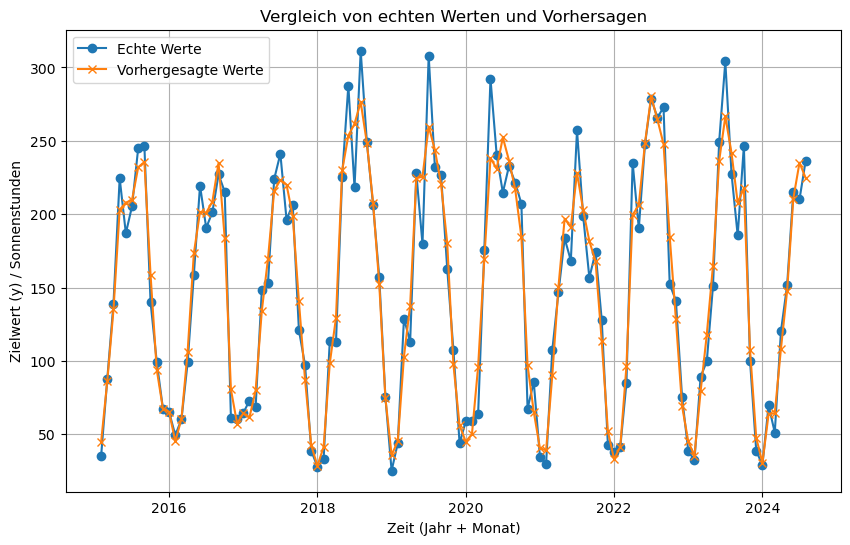

In [23]:
#Libraries importieren
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Jahre (X), Werte sind die Sonnenstunden (y)

data = {
    'year': years,  # etc.
    'month': months,
    'y_value': data_Sonnenstunden  # Zielwerte
}

df = pd.DataFrame(data)

# X und y
X = df[['year', 'month']]
y = df['y_value']

# XGBoost DMatrix erstellen
dtrain = xgb.DMatrix(X, label=y)

# Parameter für XGBoost (z.B. Regression)
params = {
    'objective': 'reg:squarederror',  # Für Regression
    'max_depth': 4,
    'learning_rate': 0.1
}

# XGBoost Modell trainieren
model = xgb.train(params, dtrain, num_boost_round=100)

# Vorhersagen
preds = model.predict(dtrain)

# Plotten der echten Werte und Vorhersagen
plt.figure(figsize=(10, 6))
plt.plot(df['year'] + df['month']/12, y, label='Echte Werte', marker='o')
plt.plot(df['year'] + df['month']/12, preds, label='Vorhergesagte Werte', marker='x')

plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y) / Sonnenstunden')
plt.title('Vergleich von echten Werten und Vorhersagen')
plt.legend()
plt.grid(True)
plt.show()

# XGBoost Modell zur Vorhersage der Strompreise (Ausgangsmodell):

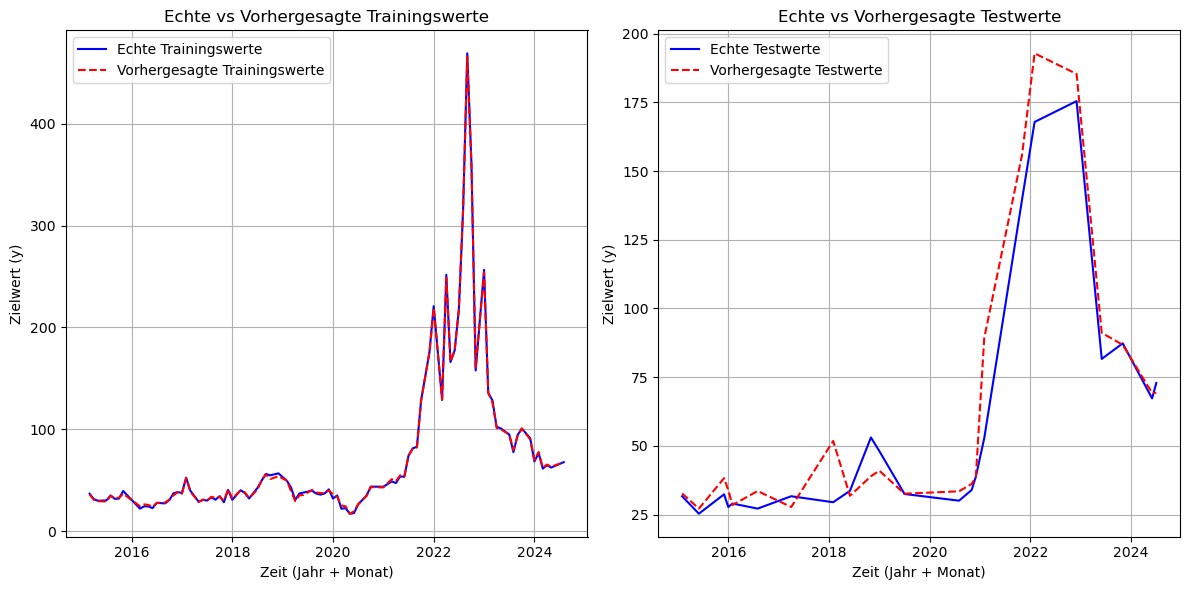

Mean Squared Error auf Trainingsdaten: 2.197836139554369
R²-Wert auf Trainingsdaten: 0.9996330991890412
Mean Squared Error auf Testdaten: 144.54711804206627
R²-Wert auf Testdaten: 0.9243934875517811


In [24]:
#Importieren der Libraries

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import shap


# Dataframe
data = {
    'year': years,  # etc.
    'month': months,
    'data_FC_load': data_FC_load,
    'data_ACT_load': data_ACT_load,
    'data_Solar_generation': data_Solar_generation,
    'data_Sonnenstunden': data_Sonnenstunden,
    'data_FC_Solar_generation': data_FC_Solar_generation,
    'data_FC_Rest': data_FC_Rest,
    'y_value': data_Durchschnittspreise  # Zielwerte
}

df = pd.DataFrame(data)

# X und y
X = df[['year', 'month', 'data_FC_load', 'data_ACT_load', 'data_Solar_generation', 'data_Sonnenstunden', 'data_FC_Solar_generation', 'data_FC_Rest']]
y = df['y_value']

# Daten aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost DMatrix Trainingsdaten
dtrain = xgb.DMatrix(X_train, label=y_train)

# XGBoost DMatrix Testdaten
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameter
params = {
    'objective': 'reg:squarederror',  # Für Regression
    'max_depth': 4,
    'learning_rate': 0.1
}

# XGBoost Modell trainieren
model = xgb.train(params, dtrain, num_boost_round=100)

# Vorhersagen für Trainings- und Testdaten
train_preds = model.predict(dtrain)
test_preds = model.predict(dtest)

# Testdaten Plotten
test_data = X_test.copy()
test_data['y_value'] = y_test.values
test_data['preds'] = test_preds

# Plot
def sort_data(df):
    return df.sort_values(by=['year', 'month'])

train_sorted = sort_data(pd.DataFrame({
    'year': X_train['year'],
    'month': X_train['month'],
    'y_value': y_train,
    'preds': train_preds
}))

test_sorted = sort_data(pd.DataFrame({
    'year': X_test['year'],
    'month': X_test['month'],
    'y_value': y_test,
    'preds': test_preds
}))

plt.figure(figsize=(12, 6))

# Trainingsdaten plotten
plt.subplot(1, 2, 1)
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['y_value'], label='Echte Trainingswerte', color='blue')
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['preds'], label='Vorhergesagte Trainingswerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Trainingswerte')
plt.legend()
plt.grid(True)

# Testdaten plotten
plt.subplot(1, 2, 2)
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['y_value'], label='Echte Testwerte', color='blue')
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['preds'], label='Vorhergesagte Testwerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Testwerte')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Berechnen und Ausgeben des Mean Squared Error und R²-Werts für Test- und Trainingsdaten
mse_train = mean_squared_error(y_train, train_preds)
r2_train = r2_score(y_train, train_preds)

mse_test = mean_squared_error(y_test, test_preds)
r2_test = r2_score(y_test, test_preds)

print(f"Mean Squared Error auf Trainingsdaten: {mse_train}")
print(f"R²-Wert auf Trainingsdaten: {r2_train}")

print(f"Mean Squared Error auf Testdaten: {mse_test}")
print(f"R²-Wert auf Testdaten: {r2_test}")


# XGBoost Modell zur Vorhersage der Strompreise mit Cross-Validation:

Durchschnittliches CV-MSE: 2850.5885218861604
Durchschnittliches CV-R²: 0.49771034903292766


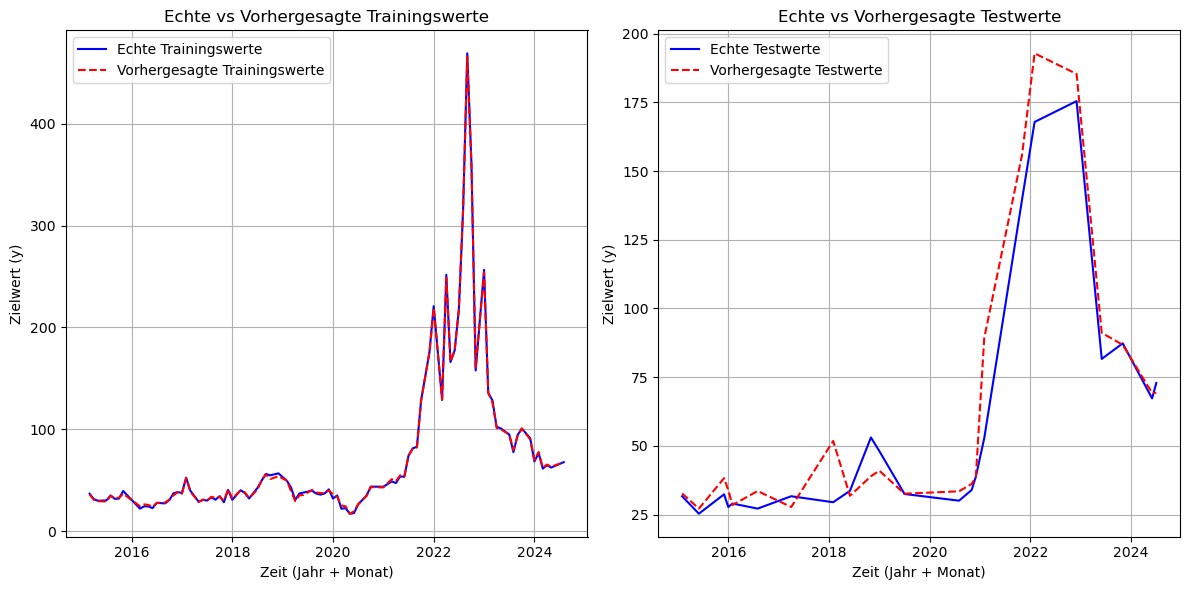

Mean Squared Error auf Trainingsdaten: 2.197836139554369
R²-Wert auf Trainingsdaten: 0.9996330991890412
Mean Squared Error auf Testdaten: 144.54711804206627
R²-Wert auf Testdaten: 0.9243934875517811


In [25]:
#Importieren der Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Dataframe
data = {
    'year': years,  # etc.
    'month': months,
    'data_FC_load': data_FC_load,
    'data_ACT_load': data_ACT_load,
    'data_Solar_generation': data_Solar_generation,
    'data_Sonnenstunden': data_Sonnenstunden,
    'data_FC_Solar_generation': data_FC_Solar_generation,
    'data_FC_Rest': data_FC_Rest,
    'y_value': data_Durchschnittspreise  # Zielwerte
}

df = pd.DataFrame(data)

# X und y
X = df[['year', 'month', 'data_FC_load', 'data_ACT_load', 'data_Solar_generation', 'data_Sonnenstunden', 'data_FC_Solar_generation', 'data_FC_Rest']]
y = df['y_value']

# Daten aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBRegressor Modell erstellen
model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=4, learning_rate=0.1, n_estimators=100)

# Cross-Validation (5-fache CV)
cv_scores_mse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Cross-Validation-Ergebnisse
print(f"Durchschnittliches CV-MSE: {-np.mean(cv_scores_mse)}")
print(f"Durchschnittliches CV-R²: {np.mean(cv_scores_r2)}")

# Modell auf Trainingsdaten fitten
model.fit(X_train, y_train)

# Vorhersagen für Trainings- und Testdaten
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Testdaten Plotten
test_data = X_test.copy()
test_data['y_value'] = y_test.values
test_data['preds'] = test_preds

# Sortiere die Daten nach Zeit für Linienzeichnung
def sort_data(df):
    return df.sort_values(by=['year', 'month'])

train_sorted = sort_data(pd.DataFrame({
    'year': X_train['year'],
    'month': X_train['month'],
    'y_value': y_train,
    'preds': train_preds
}))

test_sorted = sort_data(pd.DataFrame({
    'year': X_test['year'],
    'month': X_test['month'],
    'y_value': y_test,
    'preds': test_preds
}))

# Plotten der echten Werte und Vorhersagen für Trainings- und Testdaten
plt.figure(figsize=(12, 6))

# Trainingsdaten plotten
plt.subplot(1, 2, 1)
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['y_value'], label='Echte Trainingswerte', color='blue')
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['preds'], label='Vorhergesagte Trainingswerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Trainingswerte')
plt.legend()
plt.grid(True)

# Testdaten plotten
plt.subplot(1, 2, 2)
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['y_value'], label='Echte Testwerte', color='blue')
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['preds'], label='Vorhergesagte Testwerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Testwerte')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Mean Squared Error und R²-Werts für Test- und Trainingsdaten
mse_train = mean_squared_error(y_train, train_preds)
r2_train = r2_score(y_train, train_preds)

mse_test = mean_squared_error(y_test, test_preds)
r2_test = r2_score(y_test, test_preds)

print(f"Mean Squared Error auf Trainingsdaten: {mse_train}")
print(f"R²-Wert auf Trainingsdaten: {r2_train}")

print(f"Mean Squared Error auf Testdaten: {mse_test}")
print(f"R²-Wert auf Testdaten: {r2_test}")


Das **Ergebnis des R²-Werts** ist stark abhängig von unseren **Testdaten** – insbesondere davon, ob **Ausreißer** darin enthalten sind oder nicht.

# Analysen durch Shap Values

Feature Importance - Grafik

In [26]:
from bokeh.io import output_notebook
output_notebook()


Loading BokehJS ...

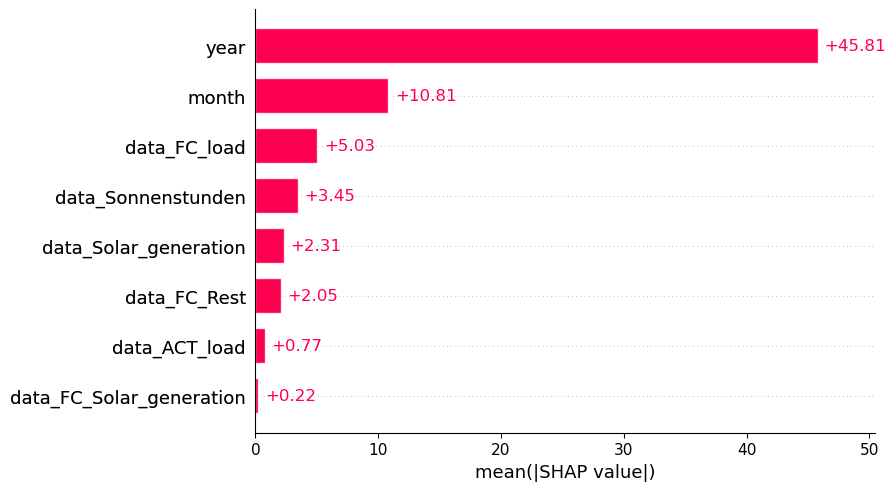

In [27]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.plots.bar(shap_values)

hohe Feature Importance vom Datum --> Ursache: Ausreißer im Jahr 2022 verursacht durch Ukraine Konflikt und darauf massiv steigenden Strompreisen

92


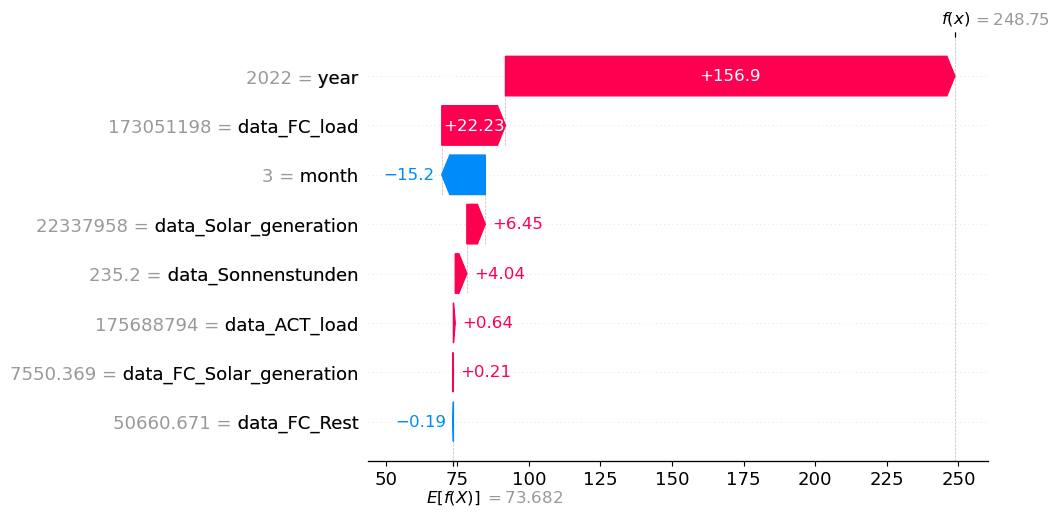

In [28]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

print(len(shap_values))

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[81])

Besonders im Jahr 2022 eine hohe Abhängigkeit vom Datum

In [29]:
shap.initjs()
# visualize all the training set predictions
shap.plots.force(shap_values) 

Jahr 2022 sorgt für massive Steigerung der Energiepreise --> Jahr sonst eher negativen Einfluss auf Preis --> startet ab 2020 (Corona) und Lage wird immer weiter zusätzlich verschärft (Ukraine Krieg)

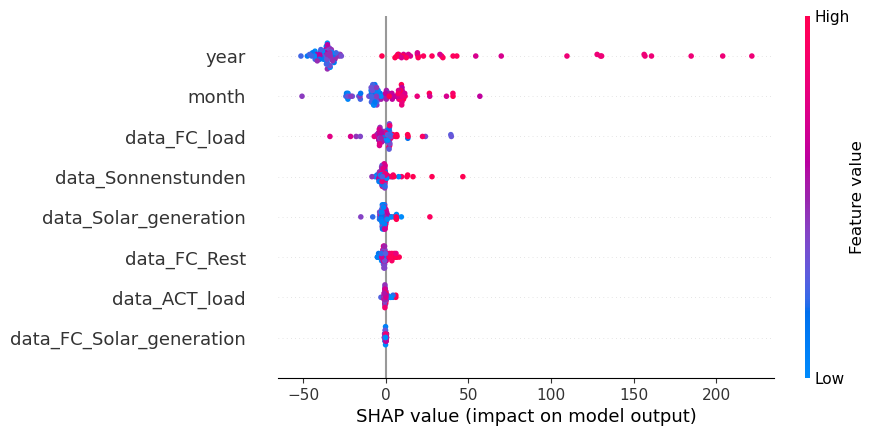

In [30]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

Das Jahr sorgt für die stärksten Ausreißer im Modell

# Finetuning des Modells durch Hyperparameter Tuning

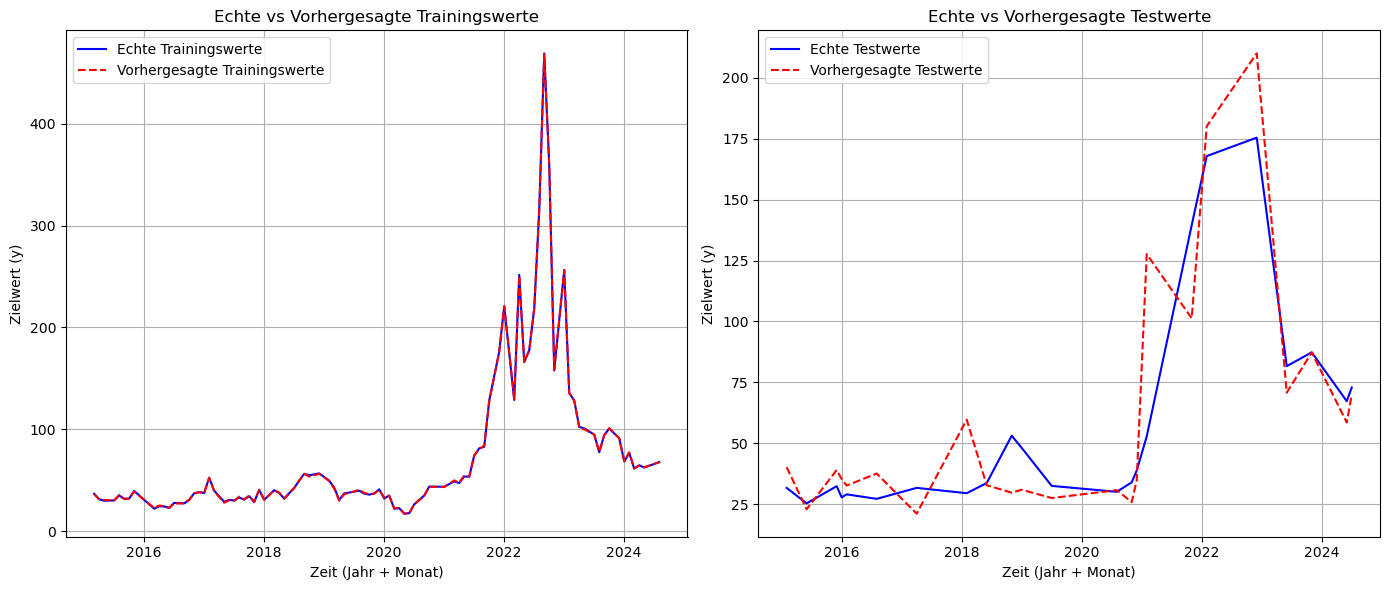

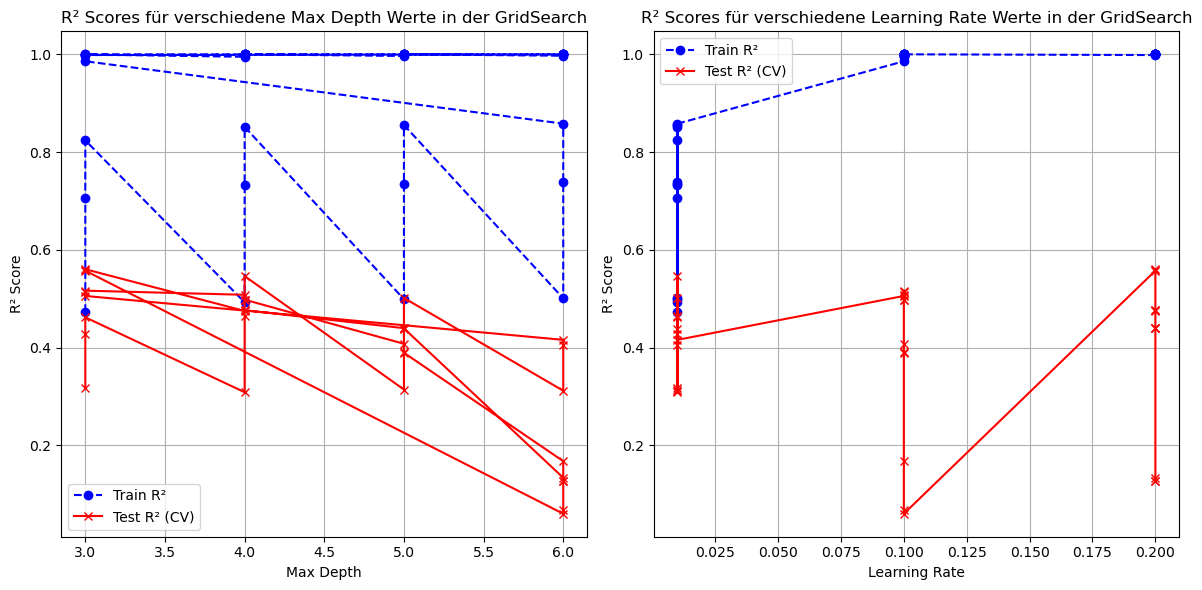

Beste Hyperparameter: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150}
Trainingsdaten: R²=0.9999471879649175, MSE=0.3163585248127552
Testdaten: R²=0.7522898713589489, MSE=473.5807015224511
Bestes R² während Cross-Validation: 0.5603103533388621


In [31]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

# Daten laden
data = {
    'year': years,  # etc.
    'month': months,
    'data_FC_load': data_FC_load,
    'data_ACT_load': data_ACT_load,
    'data_Solar_generation': data_Solar_generation,
    'data_Sonnenstunden': data_Sonnenstunden,
    'data_FC_Solar_generation': data_FC_Solar_generation,
    'data_FC_Rest': data_FC_Rest,
    'y_value': data_Durchschnittspreise
}

df = pd.DataFrame(data)

# X und y definieren
X = df[['year', 'month', 'data_FC_load', 'data_ACT_load', 'data_Solar_generation', 'data_Sonnenstunden', 'data_FC_Solar_generation', 'data_FC_Rest']]
y = df['y_value']

# Daten in Trainings- und Testdatensatz aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBRegressor Modell erstellen
model = xgb.XGBRegressor()

# Gridsearch Parameter-Raster
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150]
}

# GridSearchCV aufrufen
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

# Ergebnisse von Gridsearch in DataFrame speichern
results = pd.DataFrame(grid_search.cv_results_)

# Sortiere Datum für Plot
def sort_data(df):
    return df.sort_values(by=['year', 'month'])

# Trainingsergebnisse plotten
train_preds = grid_search.best_estimator_.predict(X_train)
train_sorted = sort_data(pd.DataFrame({
    'year': X_train['year'],
    'month': X_train['month'],
    'y_value': y_train,
    'preds': train_preds
}))

# Testergebnisse plotten
test_preds = grid_search.best_estimator_.predict(X_test)
test_sorted = sort_data(pd.DataFrame({
    'year': X_test['year'],
    'month': X_test['month'],
    'y_value': y_test,
    'preds': test_preds
}))

# Plotten der echten Werte und Vorhersagen für Trainings- und Testdaten
plt.figure(figsize=(14, 6))

# Plot für Trainingsdaten
plt.subplot(1, 2, 1)
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['y_value'], label='Echte Trainingswerte', color='blue')
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['preds'], label='Vorhergesagte Trainingswerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Trainingswerte')
plt.legend()
plt.grid(True)

# Plot für Testdaten
plt.subplot(1, 2, 2)
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['y_value'], label='Echte Testwerte', color='blue')
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['preds'], label='Vorhergesagte Testwerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Testwerte')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot der Trainings- und Test-R²-Werte für verschiedene Hyperparameter
plt.figure(figsize=(12, 6))

# Plot für max_depth
plt.subplot(1, 2, 1)
plt.plot(results['param_max_depth'], results['mean_train_score'], label='Train R²', marker='o', linestyle='--', color='blue')
plt.plot(results['param_max_depth'], results['mean_test_score'], label='Test R² (CV)', marker='x', linestyle='-', color='red')
plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.title('R² Scores für verschiedene Max Depth Werte in der GridSearch')
plt.legend()
plt.grid(True)

# Plot für learning_rate
plt.subplot(1, 2, 2)
plt.plot(results['param_learning_rate'], results['mean_train_score'], label='Train R²', marker='o', linestyle='--', color='blue')
plt.plot(results['param_learning_rate'], results['mean_test_score'], label='Test R² (CV)', marker='x', linestyle='-', color='red')
plt.xlabel('Learning Rate')
plt.ylabel('R² Score')
plt.title('R² Scores für verschiedene Learning Rate Werte in der GridSearch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Beste Hyperparameter aus GridSearch anzeigen
print(f"Beste Hyperparameter: {grid_search.best_params_}")

# Berechne die R²- und MSE-Werte für das beste Modell
y_pred_train = grid_search.best_estimator_.predict(X_train)
y_pred_test = grid_search.best_estimator_.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Trainingsdaten: R²={r2_train}, MSE={mse_train}")
print(f"Testdaten: R²={r2_test}, MSE={mse_test}")
# Beste CV R² während GridSearch
print(f"Bestes R² während Cross-Validation: {grid_search.best_score_}")


CV R^2 wird verbessert durch das Tuning

# XGBoost ohne das Datum

Durchschnittliches CV-MSE: 5699.28310660934
Durchschnittliches CV-R²: -5.752480606885963


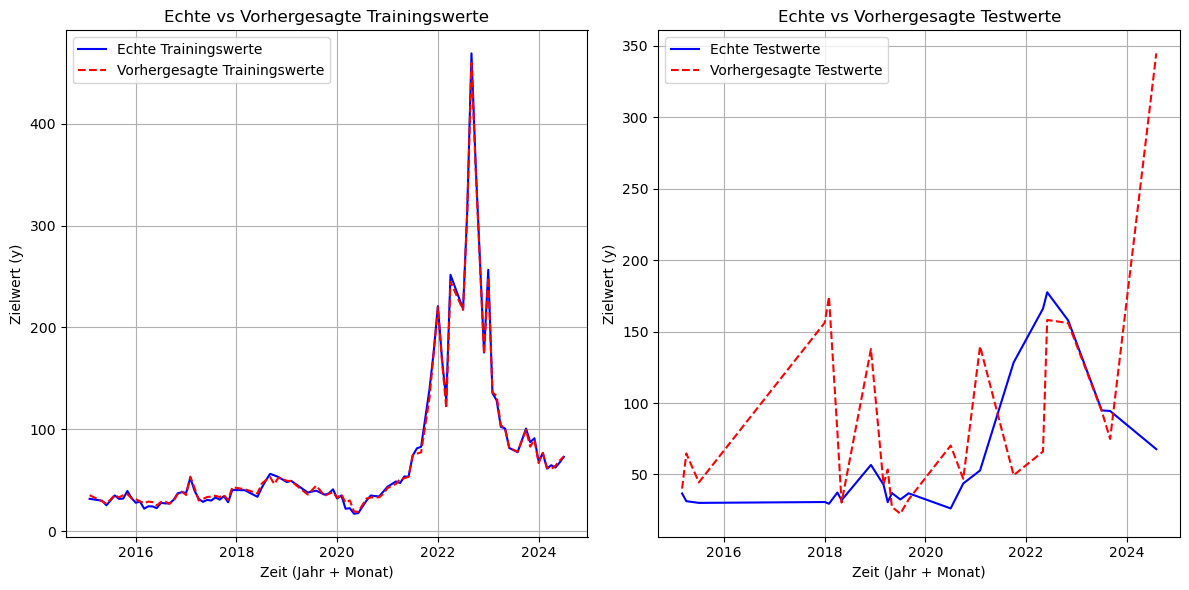

Mean Squared Error auf Trainingsdaten: 10.808787099306713
R²-Wert auf Trainingsdaten: 0.9981814503240739
Mean Squared Error auf Testdaten: 6539.631096088014
R²-Wert auf Testdaten: -1.9403066284987558


In [32]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Dataframe
data = {
    'year': years,  # etc.
    'month': months,
    'data_FC_load': data_FC_load,
    'data_ACT_load': data_ACT_load,
    'data_Solar_generation': data_Solar_generation,
    'data_Sonnenstunden': data_Sonnenstunden,
    'data_FC_Solar_generation': data_FC_Solar_generation,
    'data_FC_Rest': data_FC_Rest,
    'y_value': data_Durchschnittspreise  # Zielwerte
}

df = pd.DataFrame(data)

# X und y (year und month aus X entfernen)
X = df[['data_FC_load', 'data_ACT_load', 'data_Solar_generation', 'data_Sonnenstunden', 'data_FC_Solar_generation', 'data_FC_Rest']]
y = df['y_value']
years_months = df[['year', 'month']]

# Daten aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test, years_months_train, years_months_test = train_test_split(
    X, y, years_months, test_size=0.2, random_state=20)

# XGBRegressor Modell erstellen
model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=4, learning_rate=0.1, n_estimators=100)

# Cross-Validation (5-fache CV)
cv_scores_mse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Cross-Validation-Ergebnisse
print(f"Durchschnittliches CV-MSE: {-np.mean(cv_scores_mse)}")
print(f"Durchschnittliches CV-R²: {np.mean(cv_scores_r2)}")

# Modell auf Trainingsdaten fitten
model.fit(X_train, y_train)

# Vorhersagen für Trainings- und Testdaten
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Testdaten Plotten
test_data = years_months_test.copy()
test_data['y_value'] = y_test.values
test_data['preds'] = test_preds

# Sortiere die Daten nach Zeit Linienzeichnung
def sort_data(df):
    return df.sort_values(by=['year', 'month'])

train_sorted = sort_data(pd.DataFrame({
    'year': years_months_train['year'],
    'month': years_months_train['month'],
    'y_value': y_train,
    'preds': train_preds
}))

test_sorted = sort_data(pd.DataFrame({
    'year': years_months_test['year'],
    'month': years_months_test['month'],
    'y_value': y_test,
    'preds': test_preds
}))

# Plotten der echten Werte und Vorhersagen für Trainings- und Testdaten
plt.figure(figsize=(12, 6))

# Trainingsdaten plotten
plt.subplot(1, 2, 1)
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['y_value'], label='Echte Trainingswerte', color='blue')
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['preds'], label='Vorhergesagte Trainingswerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Trainingswerte')
plt.legend()
plt.grid(True)

# Testdaten plotten
plt.subplot(1, 2, 2)
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['y_value'], label='Echte Testwerte', color='blue')
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['preds'], label='Vorhergesagte Testwerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Testwerte')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Berechnen und Ausgeben des Mean Squared Error und R²-Werts für Test- und Trainingsdaten
mse_train = mean_squared_error(y_train, train_preds)
r2_train = r2_score(y_train, train_preds)

mse_test = mean_squared_error(y_test, test_preds)
r2_test = r2_score(y_test, test_preds)

print(f"Mean Squared Error auf Trainingsdaten: {mse_train}")
print(f"R²-Wert auf Trainingsdaten: {r2_train}")

print(f"Mean Squared Error auf Testdaten: {mse_test}")
print(f"R²-Wert auf Testdaten: {r2_test}")


Datum entscheidender Erklärungsfaktor wegen einmaligem Schock --> muss in Regression weiterhin berücksichtigt werden. Sonst kann das Modell sich die einmalige Preiserhöhung nicht erklären

# Analysen durch Shap Values ohne Datum

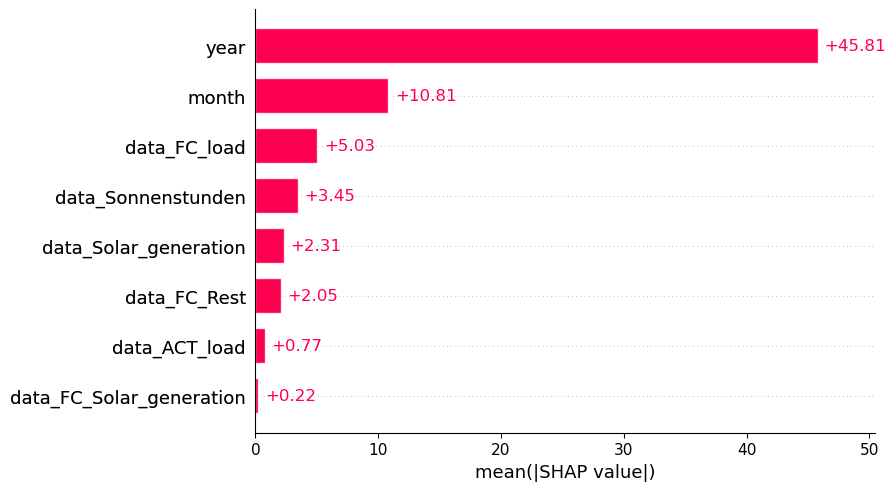

In [33]:
shap.plots.bar(shap_values)

92


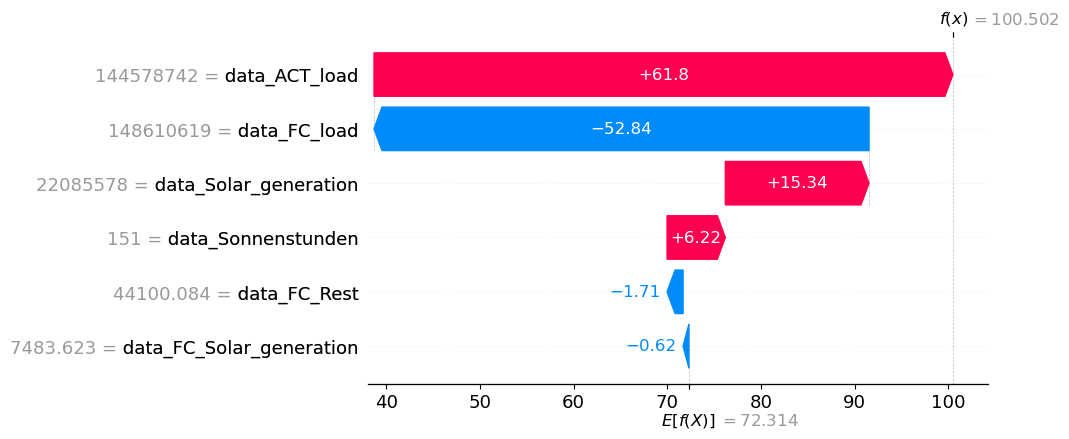

In [34]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

print(len(shap_values))

shap.plots.waterfall(shap_values[91])

Ohne das Datum hat der Verbrauch hohen Einfluss auf den Strompreis

# XGBoost nur mit Datum
Wieviel Erklärungsgehalt hat unser Modell nur durch das Datum?

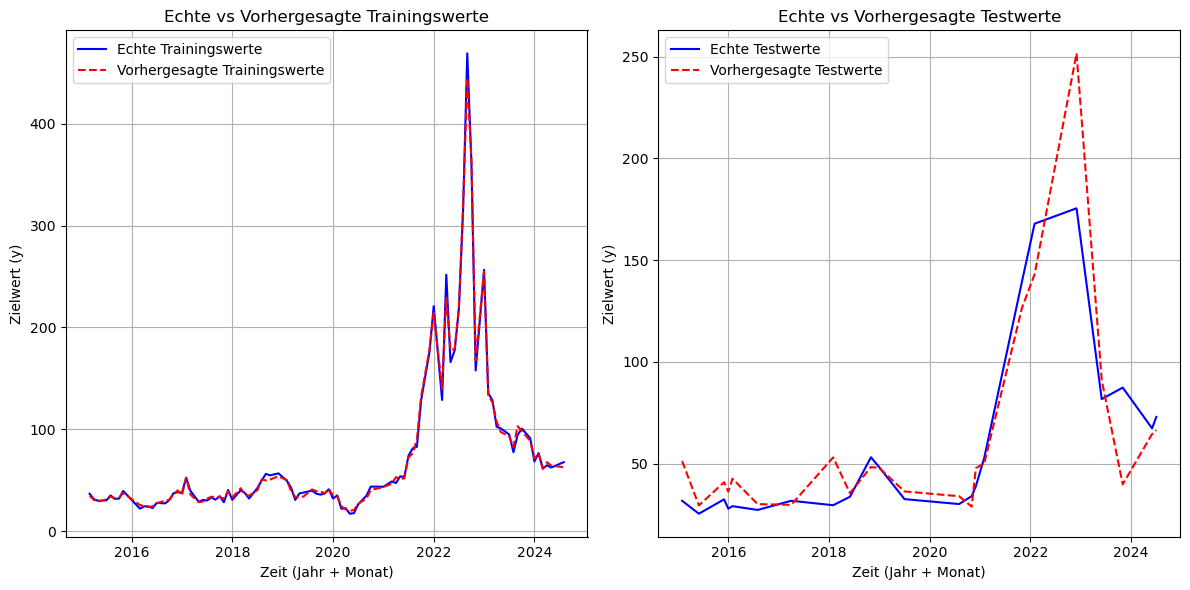

Mean Squared Error auf Trainingsdaten: 23.148516358335268
R²-Wert auf Trainingsdaten: 0.9961356493910017
Mean Squared Error auf Testdaten: 453.92152149923
R²-Wert auf Testdaten: 0.7625727608366545


In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import shap


# Dataframe
data = {
    'year': years,  # etc.
    'month': months,
    'y_value': data_Durchschnittspreise  # Zielwerte
}

df = pd.DataFrame(data)

# X und y definieren (nur year und month als erklärende Variablen)
X = df[['year', 'month']]
y = df['y_value']

# Daten aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost DMatrix Trainingsdaten
dtrain = xgb.DMatrix(X_train, label=y_train)

# XGBoost DMatrix Testdaten
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameter
params = {
    'objective': 'reg:squarederror',  # Für Regression
    'max_depth': 4,
    'learning_rate': 0.1
}

# XGBoost Modell trainieren
model = xgb.train(params, dtrain, num_boost_round=100)

# Vorhersagen für Trainings- und Testdaten
train_preds = model.predict(dtrain)
test_preds = model.predict(dtest)

# Testdaten Plotten
test_data = X_test.copy()
test_data['y_value'] = y_test.values
test_data['preds'] = test_preds

# Plot
def sort_data(df):
    return df.sort_values(by=['year', 'month'])

train_sorted = sort_data(pd.DataFrame({
    'year': X_train['year'],
    'month': X_train['month'],
    'y_value': y_train,
    'preds': train_preds
}))

test_sorted = sort_data(pd.DataFrame({
    'year': X_test['year'],
    'month': X_test['month'],
    'y_value': y_test,
    'preds': test_preds
}))

plt.figure(figsize=(12, 6))

# Trainingsdaten plotten
plt.subplot(1, 2, 1)
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['y_value'], label='Echte Trainingswerte', color='blue')
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['preds'], label='Vorhergesagte Trainingswerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Trainingswerte')
plt.legend()
plt.grid(True)

# Testdaten plotten
plt.subplot(1, 2, 2)
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['y_value'], label='Echte Testwerte', color='blue')
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['preds'], label='Vorhergesagte Testwerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Testwerte')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Berechnen und Ausgeben des Mean Squared Error und R²-Werts für Test- und Trainingsdaten
mse_train = mean_squared_error(y_train, train_preds)
r2_train = r2_score(y_train, train_preds)

mse_test = mean_squared_error(y_test, test_preds)
r2_test = r2_score(y_test, test_preds)

print(f"Mean Squared Error auf Trainingsdaten: {mse_train}")
print(f"R²-Wert auf Trainingsdaten: {r2_train}")

print(f"Mean Squared Error auf Testdaten: {mse_test}")
print(f"R²-Wert auf Testdaten: {r2_test}")


Das Datum trägt zwar viel zum Erklärungsgehalt bei, dennoch ist das Modell ohne die anderen erklärenden Variablen schlechter --> die anderen Variablen haben zwar nicht so einen großen Einfluss, sind aber dennoch relevant

## XGBoost mit Dummy Variable - Option 1 um Ausreißer zu bereinigen
Das Ziel ist es nun, den Ausreißer durch skalierte Daten und Dummy Variablen möglichst zu bereinigen, sodass das Modell den einmaligen Schock besser identifizieren kann

Durchschnittliches CV-MSE: 1629.2576159564064
Durchschnittliches CV-R²: 0.6684468789476807


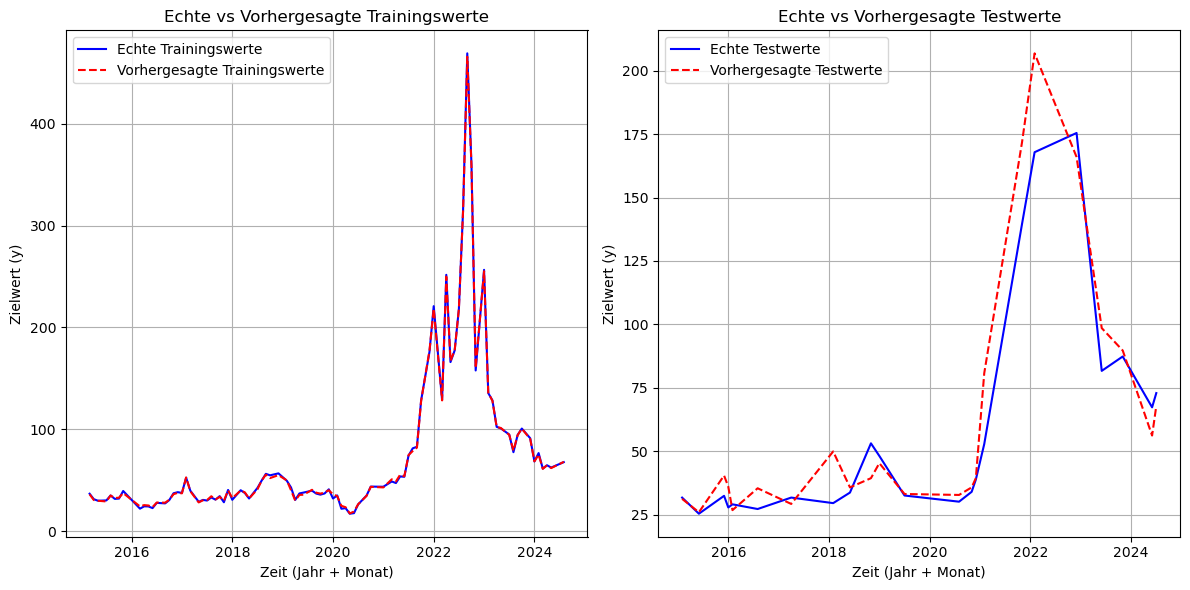

Mean Squared Error auf Trainingsdaten: 1.6161051158656783
R²-Wert auf Trainingsdaten: 0.9997302117901629
Mean Squared Error auf Testdaten: 204.53014165110338
R²-Wert auf Testdaten: 0.8930188930070552


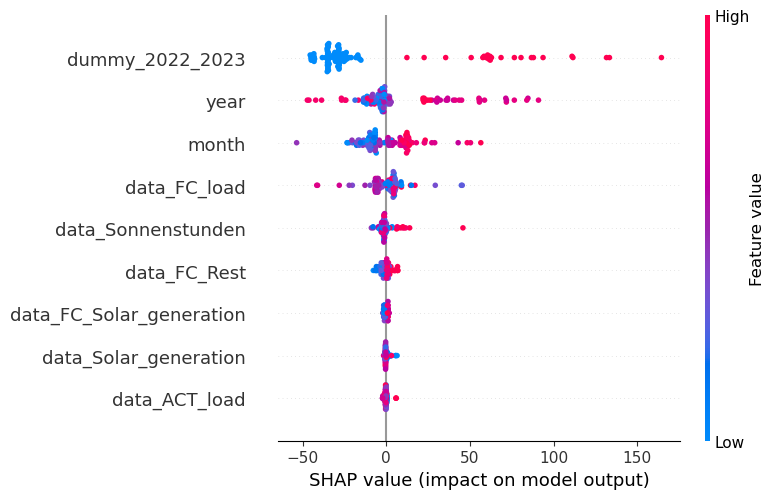

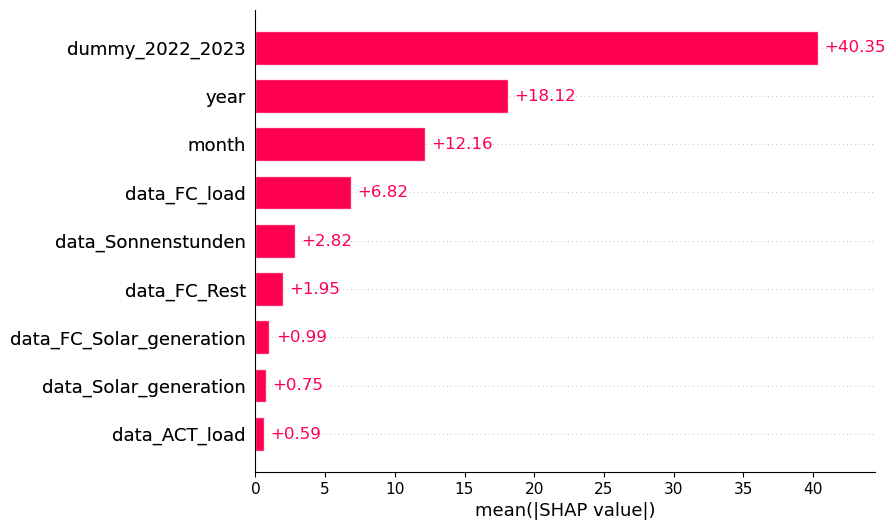

(23, 9)


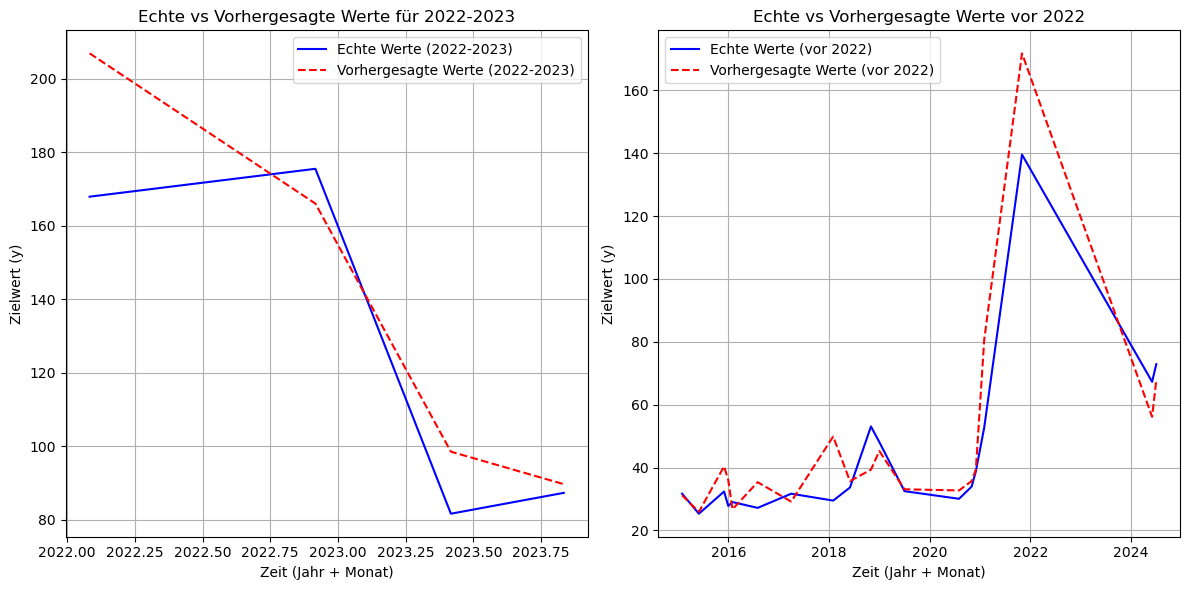

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Dataframe
data = {
    'year': years,  # etc.
    'month': months,
    'data_FC_load': data_FC_load,
    'data_ACT_load': data_ACT_load,
    'data_Solar_generation': data_Solar_generation,
    'data_Sonnenstunden': data_Sonnenstunden,
    'data_FC_Solar_generation': data_FC_Solar_generation,
    'data_FC_Rest': data_FC_Rest,
    'y_value': data_Durchschnittspreise  # Zielwerte
}

df = pd.DataFrame(data)

# Dummy-Variable für 2022 bis 2023 hinzufügen
df['dummy_2022_2023'] = np.where((df['year'] >= 2022) & (df['year'] <= 2023), 1, 0)

# X und y definieren
X = df[['year', 'month', 'data_FC_load', 'data_ACT_load', 'data_Solar_generation', 'data_Sonnenstunden', 'data_FC_Solar_generation', 'data_FC_Rest', 'dummy_2022_2023']]
y = df['y_value']

# Daten aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBRegressor Modell erstellen
model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=4, learning_rate=0.1, n_estimators=100)

# Cross-Validation (5-fache CV)
cv_scores_mse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Cross-Validation-Ergebnisse
print(f"Durchschnittliches CV-MSE: {-np.mean(cv_scores_mse)}")
print(f"Durchschnittliches CV-R²: {np.mean(cv_scores_r2)}")

# Modell auf Trainingsdaten fitten
model.fit(X_train, y_train)

# Vorhersagen für Trainings- und Testdaten
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Testdaten Plotten
test_data = pd.DataFrame(X_test, columns=['year', 'month', 'data_FC_load', 'data_ACT_load', 'data_Solar_generation', 'data_Sonnenstunden', 'data_FC_Solar_generation', 'data_FC_Rest', 'dummy_2022_2023'])
test_data['y_value'] = y_test.values
test_data['preds'] = test_preds

# Sortiere die Daten nach Zeit für Linienzeichnung
def sort_data(df):
    return df.sort_values(by=['year', 'month'])

train_sorted = sort_data(pd.DataFrame({
    'year': X_train['year'],
    'month': X_train['month'],
    'y_value': y_train,
    'preds': train_preds
}))

test_sorted = sort_data(pd.DataFrame({
    'year': X_test['year'],
    'month': X_test['month'],
    'y_value': y_test,
    'preds': test_preds
}))

# Plotten der echten Werte und Vorhersagen für Trainings- und Testdaten
plt.figure(figsize=(12, 6))

# Trainingsdaten plotten
plt.subplot(1, 2, 1)
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['y_value'], label='Echte Trainingswerte', color='blue')
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['preds'], label='Vorhergesagte Trainingswerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Trainingswerte')
plt.legend()
plt.grid(True)

# Testdaten plotten
plt.subplot(1, 2, 2)
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['y_value'], label='Echte Testwerte', color='blue')
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['preds'], label='Vorhergesagte Testwerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Testwerte')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Berechnen und Ausgeben des Mean Squared Error und R²-Werts für Test- und Trainingsdaten
mse_train = mean_squared_error(y_train, train_preds)
r2_train = r2_score(y_train, train_preds)

mse_test = mean_squared_error(y_test, test_preds)
r2_test = r2_score(y_test, test_preds)

print(f"Mean Squared Error auf Trainingsdaten: {mse_train}")
print(f"R²-Wert auf Trainingsdaten: {r2_train}")

print(f"Mean Squared Error auf Testdaten: {mse_test}")
print(f"R²-Wert auf Testdaten: {r2_test}")

# SHAP-Werte Plotten 
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns.tolist())
shap.plots.bar(shap_values)


# Testdaten Plotten 
print(X_test.shape)

# Erstelle ein neues DataFrame für die Testdaten
test_data = pd.DataFrame(X_test, columns=['year', 'month', 'data_FC_load', 'data_ACT_load', 'data_Solar_generation', 'data_Sonnenstunden', 'data_FC_Solar_generation', 'data_FC_Rest', 'dummy_2022_2023'])

# Füge die Zielwerte (y_test) und Vorhersagen (test_preds) hinzu
test_data['y_value'] = y_test.values
test_data['preds'] = test_preds

# Sortiere die Daten nach Jahr und Monat
test_sorted = sort_data(test_data)

# Daten mit Dummy 1 (2022-2023)
dummy_1_data = test_sorted[test_sorted['dummy_2022_2023'] == 1]

# Daten mit Dummy 0 (andere Jahre)
dummy_0_data = test_sorted[test_sorted['dummy_2022_2023'] == 0]

# Plotten der Vorhersagen für Dummy 1 (2022-2023)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(dummy_1_data['year'] + dummy_1_data['month']/12, dummy_1_data['y_value'], label='Echte Werte (2022-2023)', color='blue')
plt.plot(dummy_1_data['year'] + dummy_1_data['month']/12, dummy_1_data['preds'], label='Vorhergesagte Werte (2022-2023)', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Werte für 2022-2023')
plt.legend()
plt.grid(True)

# Plotten der Vorhersagen für Dummy 0 (vor 2022)
plt.subplot(1, 2, 2)
plt.plot(dummy_0_data['year'] + dummy_0_data['month']/12, dummy_0_data['y_value'], label='Echte Werte (vor 2022)', color='blue')
plt.plot(dummy_0_data['year'] + dummy_0_data['month']/12, dummy_0_data['preds'], label='Vorhergesagte Werte (vor 2022)', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Werte vor 2022')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Dummy hat starken Einfluss auf die Vorhersage ; Jedoch nicht optimal, da recht wenige Daten zur Verfügung stehen ; CV R^2 steigt aber auf 66,8%

# XGBoost mit neuen Daten (GPR inkludiert) - Option 2 um Ausreißer zu bereinigen

Neue Daten einlesen (inkl. GPR)

In [37]:
data_komplett_2 = pd.read_csv("./Daten komplett ergänzt.csv")
data_date_2 = data_komplett_2 ["Date"].to_numpy()
data_date_2 = pd.to_datetime(data_date, format='%B %Y').to_numpy()
data_FC_load_2 = data_komplett_2["Day-ahead Total Load Forecast [MW]"].to_numpy()
data_ACT_load_2 = data_komplett_2["Actual Total Load [MW]"].to_numpy()
data_Solar_generation_2 = data_komplett_2["Solar Generation (MW)"].to_numpy()
data_Sonnenstunden_2 = data_komplett_2["Solar hours (h)"].to_numpy()
data_FC_Solar_generation_2 = data_komplett_2 ["Solar Prognose (Day-Ahead D-1 18:00)"].to_numpy()
data_FC_Rest_2 = data_komplett_2 ["Solar_Prognose_diff"].to_numpy()
data_Durchschnittspreise_2 = data_komplett_2 ["Monthly_Avg_Price"].to_numpy()
data_GPRHC_DEU_2 = data_komplett_2["GPRHC_DEU"].to_numpy()
data_GPRHC_Russ_2 = data_komplett_2["GPRHC_RUS"].to_numpy()

Array Länge überprüfen:

In [38]:
# Shapes der Arrays drucken
print(f"data_FC_load_2 shape: {data_FC_load_2.shape}")
print(f"data_ACT_load_2 shape: {data_ACT_load_2.shape}")
print(f"data_Solar_generation_2 shape: {data_Solar_generation_2.shape}")
print(f"data_Sonnenstunden_2 shape: {data_Sonnenstunden_2.shape}")
print(f"data_FC_Solar_generation_2 shape: {data_FC_Solar_generation_2.shape}")
print(f"data_FC_Rest_2 shape: {data_FC_Rest_2.shape}")
print(f"data_Durchschnittspreise_2 shape: {data_Durchschnittspreise_2.shape}")

data_FC_load_2 shape: (115,)
data_ACT_load_2 shape: (115,)
data_Solar_generation_2 shape: (115,)
data_Sonnenstunden_2 shape: (115,)
data_FC_Solar_generation_2 shape: (115,)
data_FC_Rest_2 shape: (115,)
data_Durchschnittspreise_2 shape: (115,)


In [39]:
# Extrahiere Jahr und Monat
data_date_2 = pd.Series(data_date_2)
years_2 = data_date.dt.year.tolist()
months_2 = data_date.dt.month.tolist()

Angepasstes XGBoost Model:

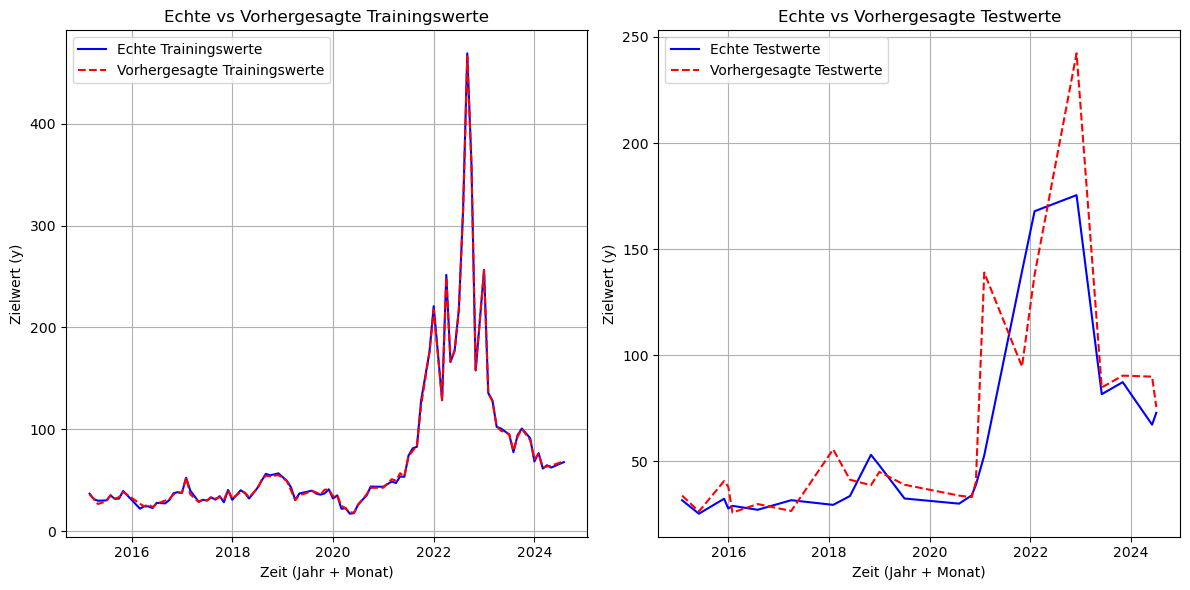

Mean Squared Error auf Trainingsdaten: 2.644618166261582
R²-Wert auf Trainingsdaten: 0.9995585146078841
Mean Squared Error auf Testdaten: 720.8835246601332
R²-Wert auf Testdaten: 0.6229361752818163


In [40]:
#XGBoost

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import shap


# Dataframe
data = {
    'year': years_2,  # etc.
    'month': months_2,
    'data_FC_load': data_FC_load_2,
    'data_ACT_load': data_ACT_load_2,
    'data_Solar_generation': data_Solar_generation_2,
    'data_Sonnenstunden': data_Sonnenstunden_2,
    'data_FC_Solar_generation': data_FC_Solar_generation_2,
    'data_FC_Rest': data_FC_Rest_2,
    'data_GPRHC_DEU': data_GPRHC_DEU_2,
    'data_GPRHC_Russ': data_GPRHC_Russ_2 , 
    'y_value': data_Durchschnittspreise  # Zielwerte
}

df = pd.DataFrame(data)

# X und y
X = df[['year', 'month', 'data_FC_load', 'data_ACT_load', 'data_Solar_generation', 'data_Sonnenstunden', 'data_FC_Solar_generation', 'data_FC_Rest', 'data_GPRHC_DEU', 'data_GPRHC_Russ']]
y = df['y_value']

# Daten aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost DMatrix Trainingsdaten
dtrain = xgb.DMatrix(X_train, label=y_train)

# XGBoost DMatrix Testdaten
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameter
params = {
    'objective': 'reg:squarederror',  # Für Regression
    'max_depth': 4,
    'learning_rate': 0.1
}

# XGBoost Modell trainieren
model = xgb.train(params, dtrain, num_boost_round=100)

# Vorhersagen für Trainings- und Testdaten
train_preds = model.predict(dtrain)
test_preds = model.predict(dtest)

# Testdaten Plotten
test_data = X_test.copy()
test_data['y_value'] = y_test.values
test_data['preds'] = test_preds

# Plot
def sort_data(df):
    return df.sort_values(by=['year', 'month'])

train_sorted = sort_data(pd.DataFrame({
    'year': X_train['year'],
    'month': X_train['month'],
    'y_value': y_train,
    'preds': train_preds
}))

test_sorted = sort_data(pd.DataFrame({
    'year': X_test['year'],
    'month': X_test['month'],
    'y_value': y_test,
    'preds': test_preds
}))

plt.figure(figsize=(12, 6))

# Trainingsdaten plotten
plt.subplot(1, 2, 1)
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['y_value'], label='Echte Trainingswerte', color='blue')
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['preds'], label='Vorhergesagte Trainingswerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Trainingswerte')
plt.legend()
plt.grid(True)

# Testdaten plotten
plt.subplot(1, 2, 2)
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['y_value'], label='Echte Testwerte', color='blue')
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['preds'], label='Vorhergesagte Testwerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Testwerte')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Berechnen und Ausgeben des Mean Squared Error und R²-Werts für Test- und Trainingsdaten
mse_train = mean_squared_error(y_train, train_preds)
r2_train = r2_score(y_train, train_preds)

mse_test = mean_squared_error(y_test, test_preds)
r2_test = r2_score(y_test, test_preds)

print(f"Mean Squared Error auf Trainingsdaten: {mse_train}")
print(f"R²-Wert auf Trainingsdaten: {r2_train}")

print(f"Mean Squared Error auf Testdaten: {mse_test}")
print(f"R²-Wert auf Testdaten: {r2_test}")


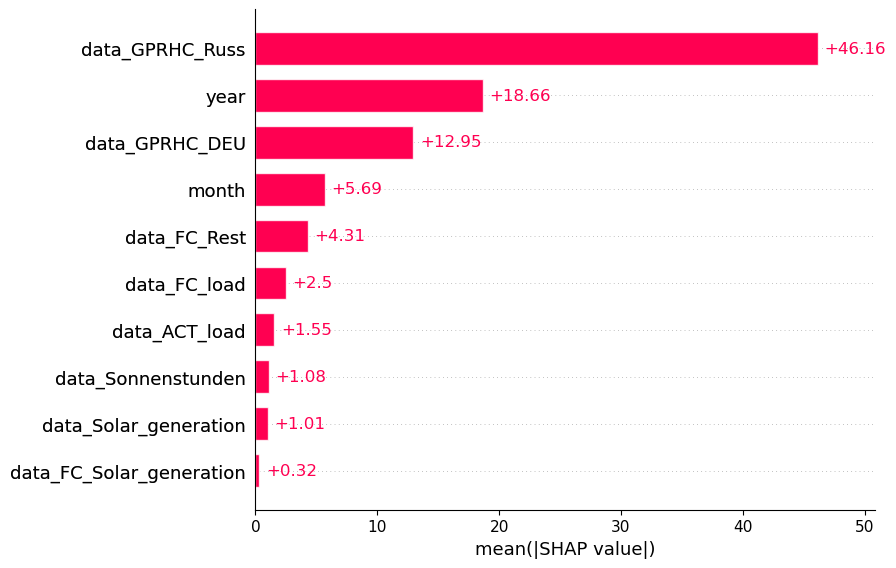

In [41]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.plots.bar(shap_values)

Relevanz vom Datum durch neue Variable gesunken --> Effekt teilweise extrahiert, aber noch nicht vollständig

92


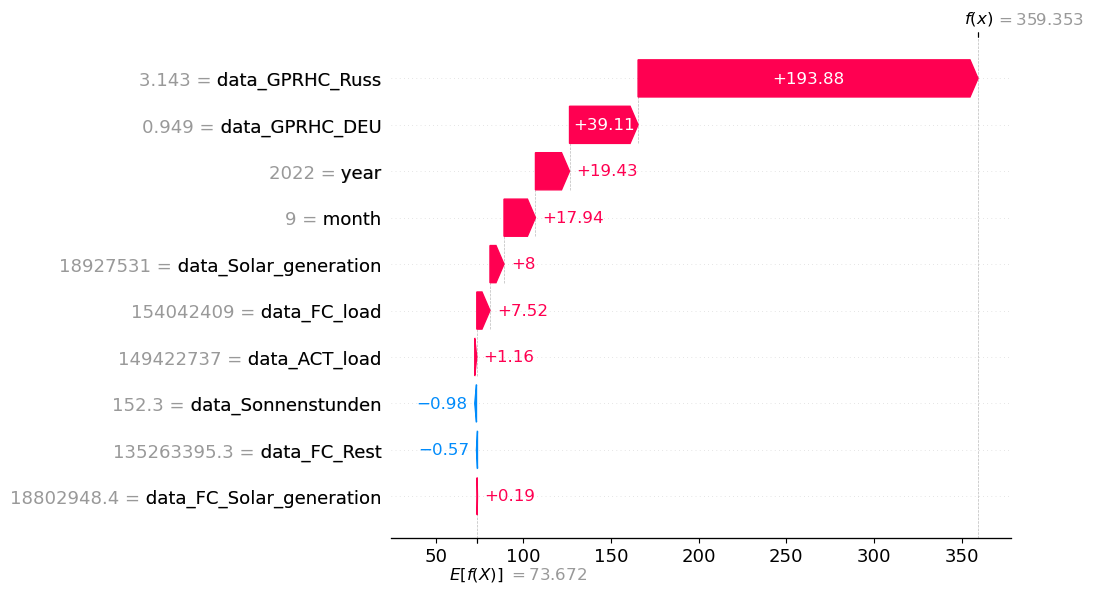

In [42]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

print(len(shap_values))

shap.plots.waterfall(shap_values[89])

Gerade im Jahr 2022 hat neue Variable entscheidende Auswirkungen auf den Preis 

Es könnten noch weitere Variablen hinzugefügt werden, neues Modell könnte erneut von Finetuning & Cross-Validation profitieren ; Datenskalierung für XGBoost nicht relevant, daher ausgelassen